<a href="https://colab.research.google.com/github/Mayankjain0807/Machine_learning_projects/blob/Machine-Learning-Projects/Amazon_content_based_recommendation_detailed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import io
import warnings
warnings.filterwarnings('ignore')
import regex as re
from numpy import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRFClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from google.colab import files
content = files.upload()

Saving amazon_prime_titles.csv to amazon_prime_titles.csv


In [3]:
data = pd.read_csv(io.BytesIO(content['amazon_prime_titles.csv']))

In [4]:
data.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",Canada,"March 30, 2021",2014,NaN,113 min,"Comedy, Drama",A small fishing village must procure a local d...
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",India,"March 30, 2021",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",United States,"March 30, 2021",2017,NaN,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",United States,"March 30, 2021",2014,NaN,69 min,Documentary,"Pink breaks the mold once again, bringing her ..."
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",United Kingdom,"March 30, 2021",1989,NaN,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...


In [5]:
# Shape of our dataset
print("The shape of our dataset is :",data.shape)

print("\n")
print("---"*12)
print("\n")

# overview of dataset
print(data.info())

The shape of our dataset is : (9668, 12)


------------------------------------


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9668 entries, 0 to 9667
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       9668 non-null   object
 1   type          9668 non-null   object
 2   title         9668 non-null   object
 3   director      7586 non-null   object
 4   cast          8435 non-null   object
 5   country       672 non-null    object
 6   date_added    155 non-null    object
 7   release_year  9668 non-null   int64 
 8   rating        9331 non-null   object
 9   duration      9668 non-null   object
 10  listed_in     9668 non-null   object
 11  description   9668 non-null   object
dtypes: int64(1), object(11)
memory usage: 906.5+ KB
None


# **NULL VALUES**

In [6]:
# Check the null values in our dataset.
data.isnull().sum()

show_id            0
type               0
title              0
director        2082
cast            1233
country         8996
date_added      9513
release_year       0
rating           337
duration           0
listed_in          0
description        0
dtype: int64

In [7]:
# Percentage of null values
round((data.isnull().sum()/len(data))*100,2)

show_id          0.00
type             0.00
title            0.00
director        21.53
cast            12.75
country         93.05
date_added      98.40
release_year     0.00
rating           3.49
duration         0.00
listed_in        0.00
description      0.00
dtype: float64

# **Handling the Null values**

In [8]:
# Make a copy of our data
amz = data.copy()

In [9]:
# lets drop the country and date_added column
amz.drop(["country",'date_added'], axis = 1, inplace = True)

In [10]:
# all null dataset columns
col = amz.loc[:,['director','cast','rating']]
col.columns

Index(['director', 'cast', 'rating'], dtype='object')

In [11]:
# lets drop the null values in other 3 column i.e director, cast and rating
for x in col.columns:
  amz.fillna({x: 'None'}, inplace = True)

In [12]:
# Percentage after handling null values
round((amz.isnull().sum()/len(amz))*100,2)

show_id         0.0
type            0.0
title           0.0
director        0.0
cast            0.0
release_year    0.0
rating          0.0
duration        0.0
listed_in       0.0
description     0.0
dtype: float64

In [13]:
# Unique values for each column
for x in amz.columns:
  print("No. of unique values in ",x,"is",data[x].nunique())

No. of unique values in  show_id is 9668
No. of unique values in  type is 2
No. of unique values in  title is 9668
No. of unique values in  director is 5774
No. of unique values in  cast is 7927
No. of unique values in  release_year is 100
No. of unique values in  rating is 24
No. of unique values in  duration is 219
No. of unique values in  listed_in is 518
No. of unique values in  description is 9414


# **EDA of our dataset**

In [14]:
amz.head()

,show_id,type,title,director,cast,release_year,rating,duration,listed_in,description
0,s1,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent",2014,None,113 min,"Comedy, Drama",A small fishing village must procure a local d...
1,s2,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",2018,13+,110 min,"Drama, International",A Metro Family decides to fight a Cyber Crimin...
2,s3,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...",2017,None,74 min,"Action, Drama, Suspense",After a man discovers his wife is cheating on ...
3,s4,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",2014,None,69 min,Documentary,"Pink breaks the mold once again, bringing her ..."
4,s5,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...",1989,None,45 min,"Drama, Fantasy",Teenage Matt Banting wants to work with a famo...


# **1- Amazon content**

Text(0.5, 1.0, 'Amazon content')

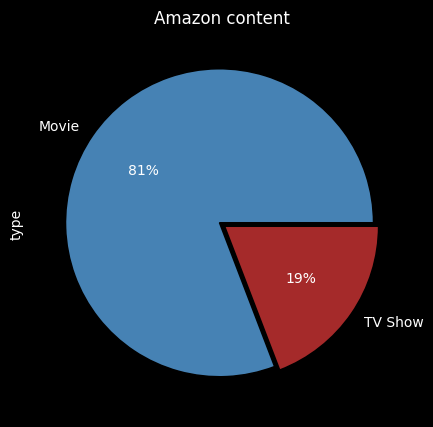

In [49]:
# find the type of content in amazon dataset

plt.figure(figsize=(6,5))
amz['type'].value_counts().plot(kind='pie', autopct='%1.0f%%',wedgeprops = {"edgecolor" : "black",
                      'linewidth': 1.1,'antialiased': True},colors=['steelblue', 'brown'],explode = (0.02,0.02))
plt.title("Amazon content")

# **2-Rating of Amazon shows**

Text(0.5, 1.0, 'Amazon Rating')

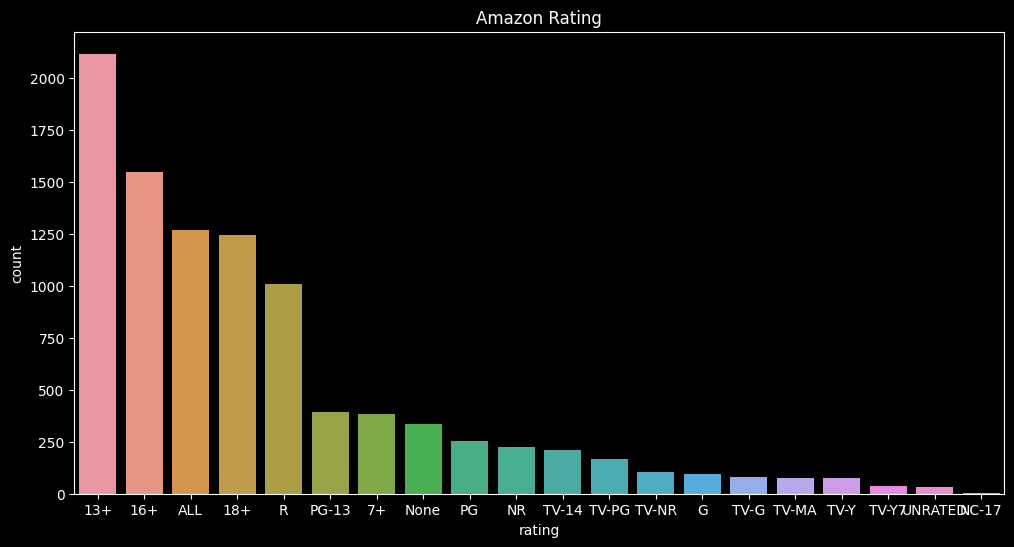

In [16]:
# Rating of shows in amazon prime
# Dark Background and figure size
plt.style.use('dark_background')
plt.figure(figsize = (12, 6))
sns.countplot(x =amz.rating, data = amz, order = amz['rating'].value_counts().index[:20])
plt.title ("Amazon Rating")

### **More than 2000 movies and TV shows are available in amazon with 13+ rating**
### **Around 1250 movies and Tv shows are available in amazon with 18+ age**

In [17]:
# Convert the string column into integer column, name duration
amz['duration'] = amz['duration'].map(lambda x: ''.join(list((x.split(" "))[0]))).astype(int)

# **3-Top 5 Longest Duration Movie**

Text(0.5, 1.0, 'Long duration movie')

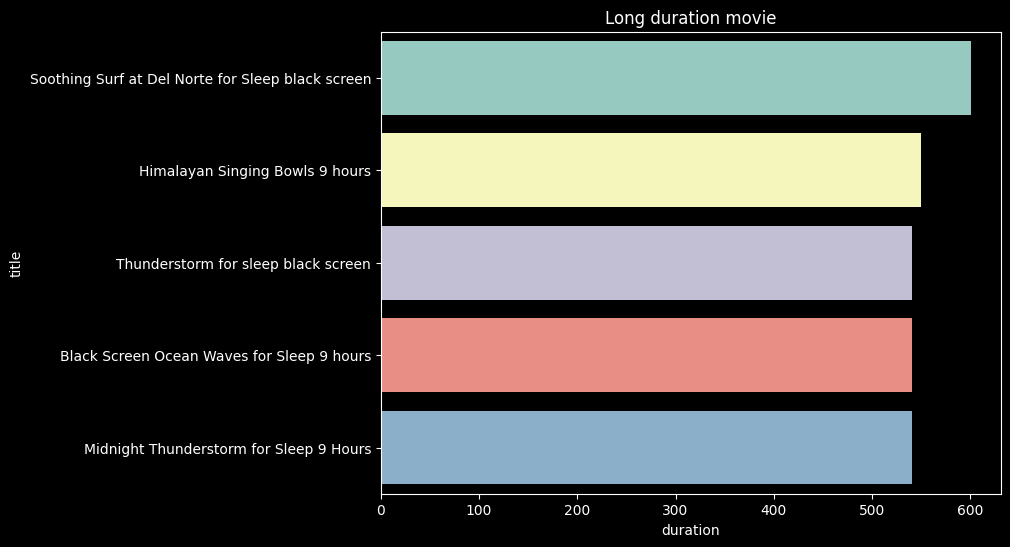

In [131]:
# Longest Movie in the Amazon prime
x = amz[amz['type'] == 'Movie'].loc[:,['title','duration']]
plt.figure(figsize=(8,6))
ax = sns.barplot(x= 'duration', y = 'title', data = x.sort_values(by= ['duration'],ascending = False)[:5])
plt.title ("Long duration movie")


# **4- Top 5 Shows with Most Season**

[Text(0, 0, '29'),
 Text(0, 0, '21'),
 Text(0, 0, '19'),
 Text(0, 0, '15'),
 Text(0, 0, '14')]

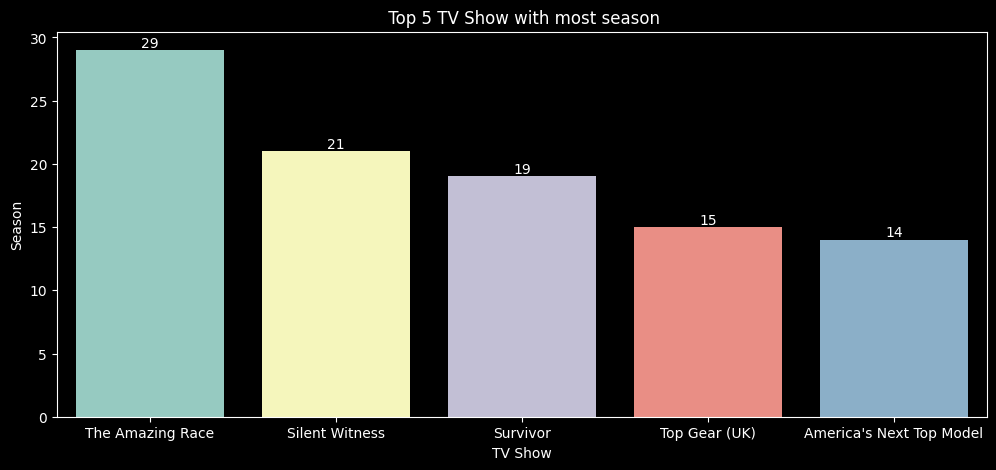

In [90]:
# Longest TV show in the Amazon prime
x = amz[amz['type'] == 'TV Show'].loc[:,['title','duration']]
plt.figure(figsize=(12,5))
ax = sns.barplot(x= 'title', y = 'duration' , data = x.sort_values(by= ['duration'],ascending = False)[:5])
plt.title (" Top 5 TV Show with most season")
plt.ylabel("Season")
plt.xlabel("TV Show")
ax.bar_label(ax.containers[0])

# **5-Movies and TV shows Release from last 10 year on Amazon platform**

Text(0.5, 1.0, 'Movies and TV shows release from last 10 year')

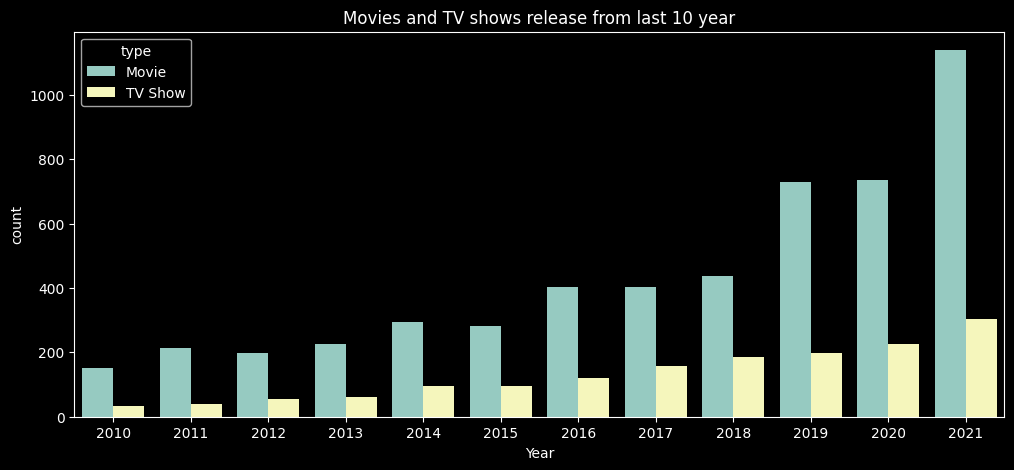

In [124]:
x = amz[amz['release_year'] >=2010]
plt.figure(figsize=(12,5))
# x = amz.sort_values(by = )
sns.countplot(data=x, x='release_year', hue="type")
plt.xlabel("Year")
plt.title("Movies and TV shows release from last 10 year")



# **Recommendation of Movies**

In [20]:
df = amz.copy()

In [21]:
df = amz[['type','title','director','cast','listed_in','description']]
df.head  ()

,type,title,director,cast,listed_in,description
0,Movie,The Grand Seduction,Don McKellar,"Brendan Gleeson, Taylor Kitsch, Gordon Pinsent","Comedy, Drama",A small fishing village must procure a local d...
1,Movie,Take Care Good Night,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar","Drama, International",A Metro Family decides to fight a Cyber Crimin...
2,Movie,Secrets of Deception,Josh Webber,"Tom Sizemore, Lorenzo Lamas, Robert LaSardo, R...","Action, Drama, Suspense",After a man discovers his wife is cheating on ...
3,Movie,Pink: Staying True,Sonia Anderson,"Interviews with: Pink, Adele, Beyoncé, Britney...",Documentary,"Pink breaks the mold once again, bringing her ..."
4,Movie,Monster Maker,Giles Foster,"Harry Dean Stanton, Kieran O'Brien, George Cos...","Drama, Fantasy",Teenage Matt Banting wants to work with a famo...


In [22]:
# convert the column values into lower alphabet and join them

df['director'] = df.director.map(lambda x: ''.join(x.lower().split(" ")))
df['type'] = df['type'].map(lambda x: ''.join(x.lower().split(" ")))
df['cast'] = df.cast.map(lambda x: (x.lower().split(",")[:3]))
df['listed_in'] = df.listed_in.map(lambda x: (x.lower().split(",")))


In [23]:
# Removing the space between same words.
for index,row in df.iterrows():
  row['cast'] = [x.replace(' ', '') for x in row['cast']]


In [24]:
def cleaned_text(text):
  # Remove special characters and make it lower case
  text = re.sub(r'[^a-zA-ZÀ-ú\s]', '', text.lower())
  #Tokenization
  tokens=text.split()
  # Remove numbers
  tokens = [token for token in tokens if not token.isdigit()]
  # Remove punctuation
  tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]
  # Remove extra whitespace
  tokens = [token.strip() for token in tokens]
  # Remove two letter words
  tokens = [token for token in tokens if len(token) > 2]
  # Join the tokens back into a single text
  cleaned_text = ' '.join(tokens)
  return cleaned_text

In [25]:
df['description'] = [cleaned_text(text) for text in df.description]

In [26]:
df.head()

,type,title,director,cast,listed_in,description
0,movie,The Grand Seduction,donmckellar,"[brendangleeson, taylorkitsch, gordonpinsent]","[comedy, drama]",small fishing village must procure local docto...
1,movie,Take Care Good Night,girishjoshi,"[maheshmanjrekar, abhaymahajan, sachinkhedekar]","[drama, international]",metro family decides fight cyber criminal thre...
2,movie,Secrets of Deception,joshwebber,"[tomsizemore, lorenzolamas, robertlasardo]","[action, drama, suspense]",after man discovers his wife cheating him with...
3,movie,Pink: Staying True,soniaanderson,"[interviewswith:pink, adele, beyoncé]",[documentary],pink breaks the mold once again bringing her c...
4,movie,Monster Maker,gilesfoster,"[harrydeanstanton, kierano'brien, georgecostigan]","[drama, fantasy]",teenage matt banting wants work with famous bu...


In [27]:
!pip install rake-nltk
from rake_nltk import Rake

In [28]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [29]:
# initializing the new column
df['Key_words'] = ""

for index, row in df.iterrows():
    plot = row['description']

    # instantiating Rake, by default is uses english stopwords from NLTK
    # and discard all puntuation characters
    r = Rake()

    # extracting the words by passing the text
    r.extract_keywords_from_text(plot)

    # getting the dictionary whith key words and their scores
    key_words_dict_scores = r.get_word_degrees()
    # print(key_words_dict_scores)

    # assigning the key words to the new column
    row['Key_words'] = list(key_words_dict_scores.keys())

# dropping the Plot column
df.drop(columns = ['description'], inplace = True)

In [30]:
df.loc[:,['Key_words']]

,Key_words
0,"[small, fishing, village, must, procure, local..."
1,"[metro, family, decides, fight, cyber, crimina..."
2,"[man, discovers, wife, cheating, neighborhood,..."
3,"[pink, breaks, mold, bringing, career, new, le..."
4,"[teenage, matt, banting, wants, work, famous, ..."
...,...
9663,"[new, york, city, street, principles, get, eas..."
9664,"[earth, adventures, cult, hit, space, patrol, ..."
9665,"[wartorn, eastern, europe, worldweary, group, ..."
9666,"[series, tells, story, diego, maradona, boy, a..."


In [ ]:
key_words_dict_scores

In [32]:
titl = df.copy()
titl.set_index('title', inplace = True)
titl.drop('type',axis = 1, inplace = True)
titl.head()

,director,cast,listed_in,Key_words
title,,,,
The Grand Seduction,donmckellar,"[brendangleeson, taylorkitsch, gordonpinsent]","[comedy, drama]","[small, fishing, village, must, procure, local..."
Take Care Good Night,girishjoshi,"[maheshmanjrekar, abhaymahajan, sachinkhedekar]","[drama, international]","[metro, family, decides, fight, cyber, crimina..."
Secrets of Deception,joshwebber,"[tomsizemore, lorenzolamas, robertlasardo]","[action, drama, suspense]","[man, discovers, wife, cheating, neighborhood,..."
Pink: Staying True,soniaanderson,"[interviewswith:pink, adele, beyoncé]",[documentary],"[pink, breaks, mold, bringing, career, new, le..."
Monster Maker,gilesfoster,"[harrydeanstanton, kierano'brien, georgecostigan]","[drama, fantasy]","[teenage, matt, banting, wants, work, famous, ..."


In [33]:
titl['bag_of_words'] = ''
column_name = titl.columns
for index, row in titl.iterrows():
    words = ''
    for col in column_name:
        if col != 'director':
          words = words + ' '.join(row[col])+ ' '
        else:
          words = words + row[col]+ ' '

    row['bag_of_words'] = words

titl.drop(columns = [col for col in titl.columns if col!= 'bag_of_words'], inplace = True)

In [34]:
titl.head()

,bag_of_words
title,
The Grand Seduction,donmckellar brendangleeson taylorkitsch gordon...
Take Care Good Night,girishjoshi maheshmanjrekar abhaymahajan sachi...
Secrets of Deception,joshwebber tomsizemore lorenzolamas robertlasa...
Pink: Staying True,soniaanderson interviewswith:pink adele beyonc...
Monster Maker,gilesfoster harrydeanstanton kierano'brien geo...


In [35]:
titl.bag_of_words.unique()[0]

'donmckellar brendangleeson taylorkitsch gordonpinsent comedy  drama small fishing village must procure local doctor secure lucrative business contract unlikely candidate big city paul lewis lands lap trial residence townsfolk rally together charm staying doctors time winds close acting mayor murray french choice pull stops  '

In [36]:
# instantiating and generating the count matrix
vectorizer = TfidfVectorizer()
count_matrix = vectorizer.fit_transform(titl['bag_of_words'])

# creating a Series for the movie titles so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(titl.index)
indices[:5]

0     The Grand Seduction
1    Take Care Good Night
2    Secrets of Deception
3      Pink: Staying True
4           Monster Maker
Name: title, dtype: object

In [37]:
c=count_matrix.todense()

In [38]:
c

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
type(count_matrix)

scipy.sparse._csr.csr_matrix

In [ ]:
vectorizer.vocabulary_

In [42]:
# generating the cosine similarity matrix

cosine_sim = cosine_similarity(count_matrix,count_matrix)

In [43]:
cosine_sim

array([[1.        , 0.00299903, 0.00316972, ..., 0.        , 0.00292609,
        0.00193469],
       [0.00299903, 1.        , 0.00516998, ..., 0.        , 0.0047726 ,
        0.00315558],
       [0.00316972, 0.00516998, 1.        , ..., 0.00899939, 0.00504424,
        0.01697992],
       ...,
       [0.        , 0.        , 0.00899939, ..., 1.        , 0.        ,
        0.00549293],
       [0.00292609, 0.0047726 , 0.00504424, ..., 0.        , 1.        ,
        0.00307884],
       [0.00193469, 0.00315558, 0.01697992, ..., 0.00549293, 0.00307884,
        1.        ]])

In [44]:
pd.DataFrame(cosine_sim)

,0,1,2,3,4,5,6,7,8,9,...,9658,9659,9660,9661,9662,9663,9664,9665,9666,9667
0,1.000000,0.002999,0.003170,0.000000,0.001998,0.000000,0.007373,0.020027,0.000000,0.002610,...,0.023437,0.007873,0.003705,0.000000,0.002328,0.056026,0.000000,0.000000,0.002926,0.001935
1,0.002999,1.000000,0.005170,0.000000,0.003258,0.000000,0.000000,0.000000,0.000000,0.004257,...,0.007725,0.004858,0.000000,0.000000,0.003797,0.000000,0.000000,0.000000,0.004773,0.003156
2,0.003170,0.005170,1.000000,0.000000,0.015886,0.000000,0.000000,0.000000,0.016193,0.004499,...,0.008164,0.005135,0.014044,0.000000,0.059441,0.048671,0.000000,0.008999,0.005044,0.016980
3,0.000000,0.000000,0.000000,1.000000,0.000000,0.006332,0.006000,0.012667,0.000000,0.000000,...,0.000000,0.026011,0.000000,0.000000,0.000000,0.024170,0.000000,0.000000,0.000000,0.006951
4,0.001998,0.003258,0.015886,0.000000,1.000000,0.031116,0.011884,0.000000,0.000000,0.002835,...,0.005145,0.003236,0.008851,0.000000,0.002529,0.000000,0.000000,0.000000,0.003179,0.026488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9663,0.056026,0.000000,0.048671,0.024170,0.000000,0.008448,0.000000,0.029733,0.000000,0.000000,...,0.000000,0.021004,0.005781,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
9664,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037644,0.016900,0.020979,...,0.011503,0.000000,0.000000,0.043210,0.000000,0.000000,1.000000,0.000000,0.003554,0.000000
9665,0.000000,0.000000,0.008999,0.000000,0.000000,0.000000,0.000000,0.000000,0.006519,0.037577,...,0.000000,0.000000,0.000000,0.000000,0.019581,0.000000,0.000000,1.000000,0.000000,0.005493
9666,0.002926,0.004773,0.005044,0.000000,0.003179,0.008938,0.000000,0.000000,0.000000,0.004153,...,0.027922,0.004740,0.000000,0.018723,0.003705,0.000000,0.003554,0.000000,1.000000,0.003079


In [45]:
cosine_sim[0]

array([1.        , 0.00299903, 0.00316972, ..., 0.        , 0.00292609,
       0.00193469])

In [46]:
# function that takes in movie title as input and returns the top 10 recommended movies
def recommendations(title, cosine_sim = cosine_sim):

    recommended_movies = []

    # gettin the index of the movie that matches the title
    idx = indices[indices == title].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    print(top_10_indexes)

    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_movies.append(list(titl.index)[i])

    return recommended_movies

In [47]:
pd.Series(cosine_sim[1]).sort_values(ascending = False)

1       1.000000
3808    0.094774
998     0.090451
9301    0.081397
3709    0.076579
          ...   
2538    0.000000
2539    0.000000
6134    0.000000
2540    0.000000
2011    0.000000
Length: 9668, dtype: float64

In [48]:
recommendations('Zis Boom Bah')

[5039, 601, 9221, 1872, 5753, 4885, 7215, 2827, 1646, 3570]


['Pororo Sing Along',
 'The Irish Comedy Tour',
 'Corey Rodrigues: People Whisperer',
 'Lewis Black: Black to the Future',
 '8 Out Of 10 Cats',
 'Baby Shark and More Kids Songs',
 "Tayo's Summer Song Series",
 'Claudia Oshry: Disgraced Queen',
 'Mister Maker',
 '#IMomSoHard Live']